In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
if 'SUMO_HOME' in os.environ:
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
import traci
import traci.constants as tc

In [2]:
sumoBinary = "/usr/bin/sumo-gui"
sumoCmd = [sumoBinary, "-c", "osm.sumocfg"]

Códigos para cada uma das variáveis:

In [3]:
SPEED = 64
POSITION = 66
ACCELERATION = 114
ANGLE = 67
DEPATURE = 58

In [4]:
vehID = "trip"

Recebendo todas as variáveis para cada instante de execução e armazenando em all_variables:

In [5]:
def get_all_variables():
    traci.start(["sumo", "-c", "osm.sumocfg"])
    all_variables = []
    while traci.simulation.getMinExpectedNumber() > 0:
        for veh_id in traci.simulation.getDepartedIDList():
            traci.vehicle.subscribe(veh_id, [tc.VAR_POSITION, tc.VAR_SPEED, tc.VAR_ACCELERATION, tc.VAR_DEPARTURE, tc.VAR_ANGLE])
        variables = traci.vehicle.getAllSubscriptionResults()

        all_variables.append(variables.copy())

        traci.simulationStep()
    traci.close()
    return all_variables

In [6]:
# Devolve o tempo de departure do veículo
def get_departure(all_variables, vehID):
    for x in all_variables:
        if x:
            return x[vehID][DEPATURE]
    return None

Função para o plot das variáveis

In [7]:
def static_plots(all_variables):
    %matplotlib inline
    plt.ioff()
    time = np.arange(0, len(all_variables), 1.0)

    departure = get_departure(all_variables, vehID)

    fig, ax = plt.subplots(2, 2, figsize=(20, 10))
    ax[0,0].plot(time, [x[vehID][SPEED] if x else 0 for x in all_variables], label='Speed', color='b')
    ax[0,0].axvline(x=departure, color='r', linestyle='--', label='Departure')
    ax[0,0].set_xlabel('Exec Time')
    ax[0,0].set_ylabel('Speed')
    ax[0,0].legend()

    ax[0,1].plot(time, [x[vehID][ACCELERATION] if x else 0 for x in all_variables], label='Acceleration', color='g')
    ax[0,1].axvline(x=departure, color='r', linestyle='--', label='Departure')
    ax[0,1].set_xlabel('Exec Time')
    ax[0,1].set_ylabel('Acceleration')
    ax[0,1].legend()

    ax[1,0].plot(time, [x[vehID][ANGLE] if x else 0 for x in all_variables], label='Angle', color='purple')
    ax[1,0].set_xlabel('Exec Time')
    ax[1,0].set_ylabel('Angle')
    ax[1,0].axvline(x=departure, color='r', linestyle='--', label='Departure')

    ax[1,1].plot([x[vehID][POSITION][0] if x else all_variables[int(departure + 1)][vehID][POSITION][0] for x in all_variables], [x[vehID][POSITION][1] if x else all_variables[int(departure + 1)][vehID][POSITION][1] for x in all_variables], label='Position', color='y')
    ax[1,1].set_xlabel('X pos')
    ax[1,1].set_ylabel('Y pos')
    plt.draw()
    plt.show()

 Retrying in 1 seconds
***Starting server on port 54025 ***
Loading net-file from 'osm.net.xml.gz' ... done (570ms).
Loading additional-files from 'park.add.xml' ... done (57ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Simulation ended at time: 407.00
Reason: TraCI requested termination.
Performance: 
 Duration: 0.44s
 TraCI-Duration: 0.28s
 Real time factor: 920.814
 UPS: 895.927602
Vehicles: 
 Inserted: 1
 Running: 0
 Waiting: 0
Statistics (avg of 1):
 RouteLength: 3539.56
 Speed: 8.94
 Duration: 396.00
 WaitingTime: 33.00
 TimeLoss: 137.97
 DepartDelay: 0.00

DijkstraRouter answered 2 queries and explored 462.50 edges on average.
DijkstraRouter spent 0.00s answering queries (2.00ms on average).


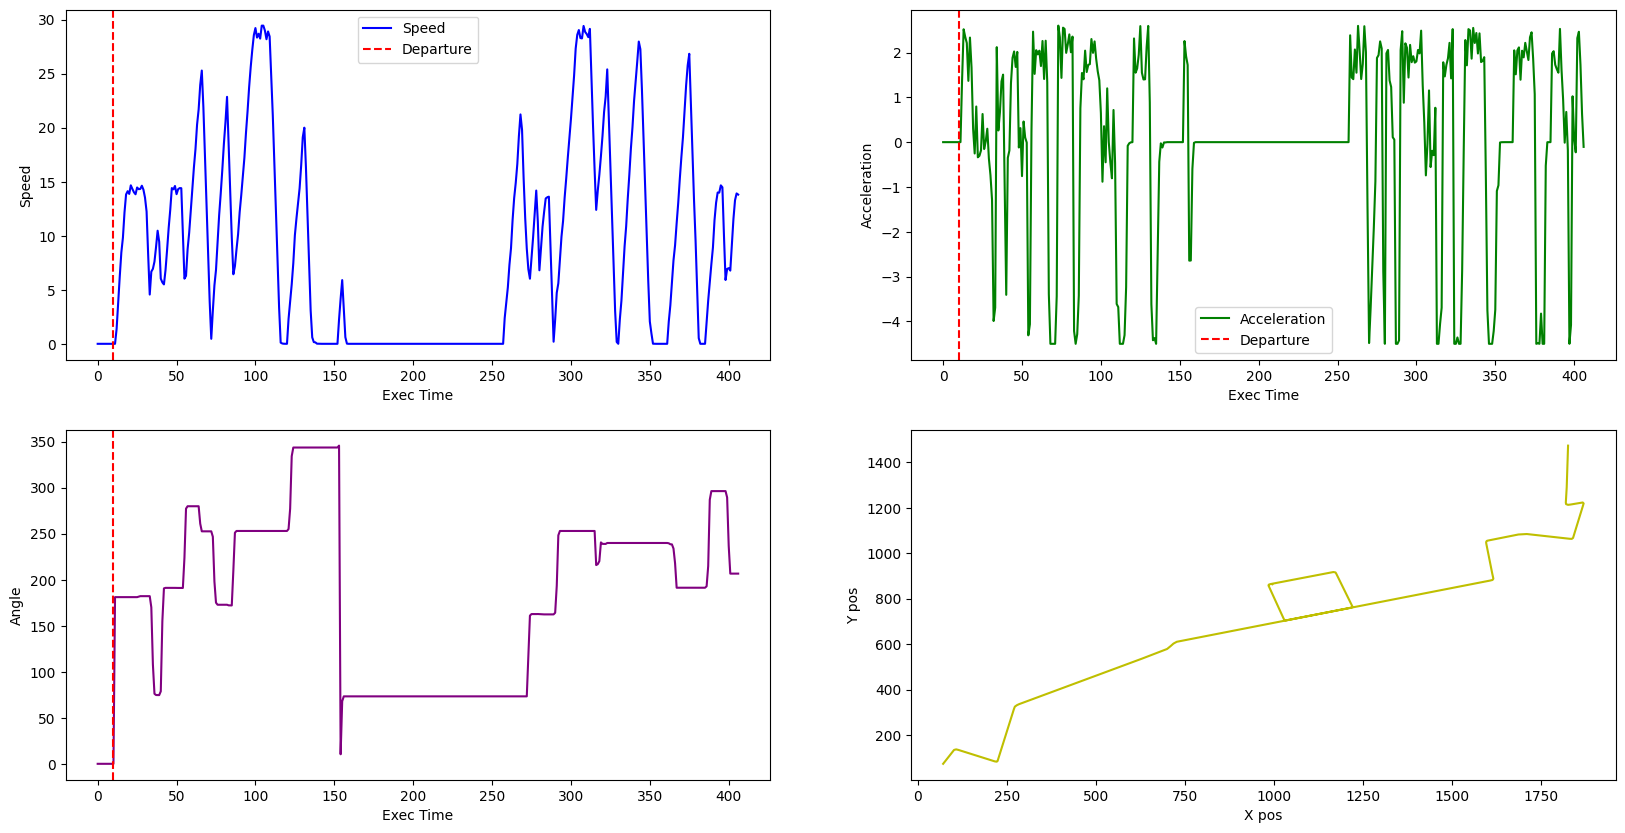

In [8]:

static_plots(get_all_variables())

In [9]:
traci.close()

FatalTraCIError: Not connected.

Criando gráfico dinâmico que roda juntamente com a simulação:

In [9]:
def dynamic_simulation():
    %matplotlib
    plt.ion()
    fig, ax = plt.subplots(2, 2, figsize=(30, 20))
    all_variables = []
    speed = []
    acc = []
    x = []
    y = []
    angle = []
    traci.start(["sumo", "-c", "osm.sumocfg"])
    while traci.simulation.getMinExpectedNumber() > 0:
        for veh_id in traci.simulation.getDepartedIDList():
            traci.vehicle.subscribe(veh_id, [tc.VAR_POSITION, tc.VAR_SPEED, tc.VAR_ACCELERATION, tc.VAR_DEPARTURE, tc.VAR_ANGLE])
        variables = traci.vehicle.getAllSubscriptionResults()
        all_variables.append(variables.copy())
        time = np.arange(0, len(all_variables), 1.0)
        
        if variables:
            speed.append(variables[vehID][SPEED])
            acc.append(variables[vehID][ACCELERATION])
            x.append(variables[vehID][POSITION][0])
            y.append(variables[vehID][POSITION][1])
            angle.append(variables[vehID][ANGLE])
            ax[0,0].clear()
            ax[0,0].plot(time, speed, label='Speed', color='b')
            ax[0,0].set_xlabel('Exec Time')
            ax[0,0].set_ylabel('Speed')
            ax[0,0].legend()
            
            ax[0,1].clear()
            ax[0,1].plot(time, acc, label='Acceleration', color='r')
            ax[0,1].set_xlabel('Exec Time')
            ax[0,1].set_ylabel('Acceleration')
            ax[0,1].legend()

            ax[1,0].clear()
            ax[1,0].plot(time, angle, label='Angle', color='g')
            ax[1,0].set_xlabel('Exec Time')
            ax[1,0].set_ylabel('Angle')
            ax[1,0].legend()

            ax[1,1].clear()
            ax[1,1].plot(x, y, label='Position', color='y')
            ax[1,1].set_xlim(0, 1600)
            ax[1,1].set_ylim(0, 1900)
            ax[1,1].set_xlabel('X pos')
            ax[1,1].set_ylabel('Y pos')
            ax[1,1].legend()
            
            plt.draw()
            plt.pause(0.01)
        else:
            speed.append(0)
            acc.append(0)
            angle.append(0)

        traci.simulationStep()
    traci.close()
    plt.ioff()
    plt.show()

In [11]:
dynamic_simulation()

Using matplotlib backend: <object object at 0x7c79050b6080>
 Retrying in 1 seconds
***Starting server on port 42007 ***
Loading net-file from 'osm.net.xml.gz' ... done (518ms).
Loading additional-files from 'park.add.xml' ... done (58ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Simulation ended at time: 407.00
Reason: TraCI requested termination.
Performance: 
 Duration: 150.83s
 TraCI-Duration: 150.65s
 Real time factor: 2.69842
 UPS: 2.625490
Vehicles: 
 Inserted: 1
 Running: 0
 Waiting: 0
Statistics (avg of 1):
 RouteLength: 3539.56
 Speed: 8.94
 Duration: 396.00
 WaitingTime: 33.00
 TimeLoss: 137.97
 DepartDelay: 0.00

DijkstraRouter answered 2 queries and explored 462.50 edges on average.
DijkstraRouter spent 0.00s answering queries (1.50ms on average).
